# Libraries

In [76]:
import sqlite3
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV

from lazypredict.Supervised import LazyClassifier
from sklearn.ensemble import ExtraTreesClassifier

# Data Importing

In [77]:
db_path = './data/dbs/TransaccionesBAC.db'

conn = sqlite3.connect(db_path)

cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

cursor.close()

In [78]:
dataframes = {}

for table in tables:
    table_name = table[0]
    if table_name != "sqlite_sequence":
        query = f"SELECT * FROM {table_name}"
        df = pd.read_sql_query(query, conn)
        dataframes[table_name] = df

conn.close()

In [79]:
debito_CRC = dataframes['Transacciones_Tarjeta_Debito_2320']
debito_USD = dataframes['Transacciones_Tarjeta_Debito_3193']

### Data Preparation

In [80]:
df_combined = pd.concat([debito_USD, debito_CRC], ignore_index=True)

categories = df_combined['Category_1'].unique()

tfidf = TfidfVectorizer(max_features=100)
tfidf_matrix = tfidf.fit_transform(df_combined['Description'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
df_combined.reset_index(drop=True, inplace=True)
tfidf_df.reset_index(drop=True, inplace=True)
df_combined = pd.concat([df_combined, tfidf_df], axis=1)
df_combined.drop(columns=['Description'], inplace=True)

df_combined['Transaction_Date'] = pd.to_datetime(df_combined['Transaction_Date'], format='%d/%m/%Y')
df_combined['Year'] = df_combined['Transaction_Date'].dt.year
df_combined['Month'] = df_combined['Transaction_Date'].dt.month
df_combined['Day'] = df_combined['Transaction_Date'].dt.day
df_combined.drop('Transaction_Date', axis=1, inplace=True)

df_combined['Transaction_Code'] = df_combined['Transaction_Code'].astype('category').cat.codes

df_combined['Account'] = df_combined['Account'].astype('category').cat.codes

df_combined['Currency'] = df_combined['Currency'].astype('category').cat.codes

df_combined['Transaction_Reference'] = df_combined['Transaction_Reference'].astype('int64')

df_combined['Category_1'] = df_combined['Category_1'].astype('category').cat.codes

categories_number = df_combined['Category_1'].unique()

In [81]:
X = df_combined.drop(columns=['id', 'Category_1'])
y = df_combined['Category_1']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1203)

### Evaluation of various classification models

In [82]:
lazy_clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = lazy_clf.fit(X_train, X_test, y_train, y_test)

 97%|█████████▋| 31/32 [00:02<00:00, 20.34it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1055
[LightGBM] [Info] Number of data points in the train set: 845, number of used features: 42
[LightGBM] [Info] Start training from score -2.206737
[LightGBM] [Info] Start training from score -6.046189
[LightGBM] [Info] Start training from score -1.052361
[LightGBM] [Info] Start training from score -0.627869
[LightGBM] [Info] Start training from score -5.353042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

100%|██████████| 32/32 [00:02<00:00, 12.33it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [83]:
pd.DataFrame(models.sort_values(by="Accuracy", ascending=False).to_dict())

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
ExtraTreesClassifier,0.86,0.67,None,0.86,0.11
BaggingClassifier,0.86,0.68,None,0.86,0.05
RandomForestClassifier,0.86,0.67,None,0.86,0.12
DecisionTreeClassifier,0.84,0.66,None,0.84,0.01
LinearSVC,0.84,0.91,None,0.84,0.30
LinearDiscriminantAnalysis,0.83,0.61,None,0.83,0.03
LabelSpreading,0.82,0.63,None,0.82,0.03
LabelPropagation,0.82,0.63,None,0.82,0.02
SVC,0.82,0.61,None,0.82,0.03
RidgeClassifierCV,0.82,0.61,None,0.82,0.03


# Model Creation

In [114]:
cls = ExtraTreesClassifier(n_estimators=100, random_state=1303)
cls.fit(X_train, y_train)

y_pred = cls.predict(X_test)

### Model Evaluation

In [115]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
report_df

,precision,recall,f1-score,support
0,1.00,1.00,1.00,23.00
2,0.87,0.84,0.85,85.00
3,0.88,0.90,0.89,103.00
4,0.00,0.00,0.00,1.00
accuracy,0.88,0.88,0.88,0.88
macro avg,0.69,0.68,0.69,212.00
weighted avg,0.88,0.88,0.88,212.00


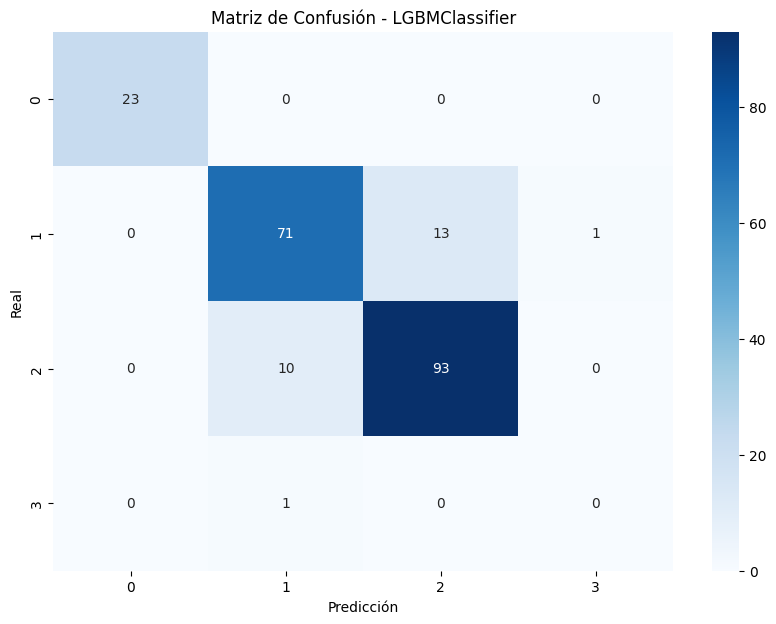

0.8820754716981132

In [116]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.title('Matriz de Confusión - LGBMClassifier')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

accuracy

### Hyperparameter Tuning

In [117]:
def stepArray(start, end, step):
    return [start + i * step for i in range(int((end - start) / step))]

In [161]:
param_dist = {
    #'n_estimators': stepArray(1, 50, 1),
    'criterion': ['gini', 'entropy', 'log_loss'], #stepArray(0.001, 0.5, 0.01)
    'max_depth': stepArray(1, 500, 1),
    'min_samples_split': [1, 2, 3, 5, 10], #stepArray(0, 100, 5)
    #'min_samples_leaf': [1, 2, 3, 5, 10], #stepArray(0.01, 1, 0.005)
    #'max_leaf_nodes': [None, 10, 20, 30, 40, 50], #stepArray(10, 100, 10)
}

random_search = RandomizedSearchCV(
    estimator=ExtraTreesClassifier(n_estimators=37, random_state=1303),
    param_distributions=param_dist,
    n_iter=500,
    scoring='accuracy',
    cv=10,
    verbose=1,
    random_state=1203,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
best_params = random_search.best_params_

optimized_y_pred = best_model.predict(X_test)
optimized_accuracy = accuracy_score(y_test, optimized_y_pred)
optimized_report = classification_report(y_test, optimized_y_pred)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits


In [162]:
print(f"Mejores hiperparámetros: {best_params}")
print(f"Precisión del modelo optimizado: {optimized_accuracy}")
print(f"Precisión del modelo optimizado - Precisión del modelo viejo: {optimized_accuracy-accuracy}")
print("\nReporte de Clasificación:")
print(optimized_report)

Mejores hiperparámetros: {'min_samples_split': 2, 'max_depth': 31, 'criterion': 'entropy'}
Precisión del modelo optimizado: 0.8443396226415094
Precisión del modelo optimizado - Precisión del modelo viejo: -0.037735849056603765

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           2       0.81      0.80      0.80        85
           3       0.84      0.85      0.85       103
           4       0.00      0.00      0.00         1

    accuracy                           0.84       212
   macro avg       0.66      0.66      0.66       212
weighted avg       0.84      0.84      0.84       212



In [163]:
cls = ExtraTreesClassifier(n_estimators=37, criterion='gini', random_state=1303)
cls.fit(X_train, y_train)

y_pred = cls.predict(X_test)

In [164]:
accuracy_new = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
report_df
accuracy_new - accuracy

0.0